In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Findings:

## Step 2: Explore what the features tell us about the output variable.
The output variable is very inbalanced. 89% of clients did not subscribe the deposite.

Continuous variables is very spread out and skewed.

There are some outliers in balance, and duration. Will remove these outliers because the number of ouliers is very small.

## Step 3: Using any of the features, build a model to predict the output variable and explain why or why not a feature is included in the model.
I built stacking model with estimators as logistic regression, random forest tree, and gradient boosting. The stack model picks the different characteristics from each model and generates an aggregated results. 

## Step 4: Report how accurate the model predicts a test set.

Due to the outcome variable is very inbalanced, the accuracy score is not appropriate to measure the model performance. 

I built 4 different stacking models and the model 3 has a slighter higher performance than the other models with the metrics on the test set of data:

Accuracy: 0.872

Precision: 0.421

Recall: 0.83

F1: 0.58

The model has a high score on the sensitivity, which means if a client described the deposite, it could fairly accurately predict it. Nevertheless, when it predicts a client as yes, it is not very accurate due to the precision score is low.

## Steps in the future:

Try to collect more variables.

The duration of call has a high positive coefficient on the outcome variable, and also has high feature performance from random forest model. Therefore, it is suggested long conversation engages clients more and would help convert the client to subscribe the deposite. 


In [2]:
# get the data
df = pd.read_csv('bank-full.csv')

In [3]:
# create a list for columns
columns = df.columns.values[0]
columns = re.sub(r'[" "]', '', columns).split(";")

In [4]:
# reform the table:
data=[]
for row in df['age;"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"']:
    data.append((re.sub(r'[" "]', '', row).split(";")))  

# transform the list of lists into DataFrame
bank_df = pd.DataFrame(data, columns = columns)

# convert datatypes for numerical variables or numbers
bank_df = bank_df.astype({'age':'int', 'balance':'int', 'duration':'int', 'pdays':'int', 'duration': 'int', 'campaign':'int', 'pdays':'int', 'previous':'int'})

# create a new variable that combines day and month
bank_df['day_month'] = bank_df['day']+'-'+bank_df['month']

bank_df['y']=(bank_df['y']=='yes').astype('int')

In [6]:
# check missing values
bank_df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
day_month    0
dtype: int64

In [7]:
# look at the data
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,day_month
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,5-may
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,5-may
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,5-may
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,5-may
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,5-may


In [8]:
# desriptive statistics for numerical variables
bank_df.describe()

,age,balance,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [69]:
bank_df['y'].value_counts(normalize=True)

0    0.88607
1    0.11393
Name: y, dtype: float64

## Findings:
Data are very spread out, very skewed on most of features. 
1. Continuous variables is very spread out and skewed. 
2. There are some outliers in balance, and duration. Will remove these outliers because the number of ouliers is very small.

In [57]:
## revmove outliers. 
bank_df =bank_df[(bank_df['balance']<8000) & (bank_df['duration']<3000) & (bank_df['balance']> -1500) & (bank_df['pdays']<400)]

## Visualize the relationship between features and target variable

W0723 16:11:49.841504 4599463360 legend.py:1282] No handles with labels found to put in legend.


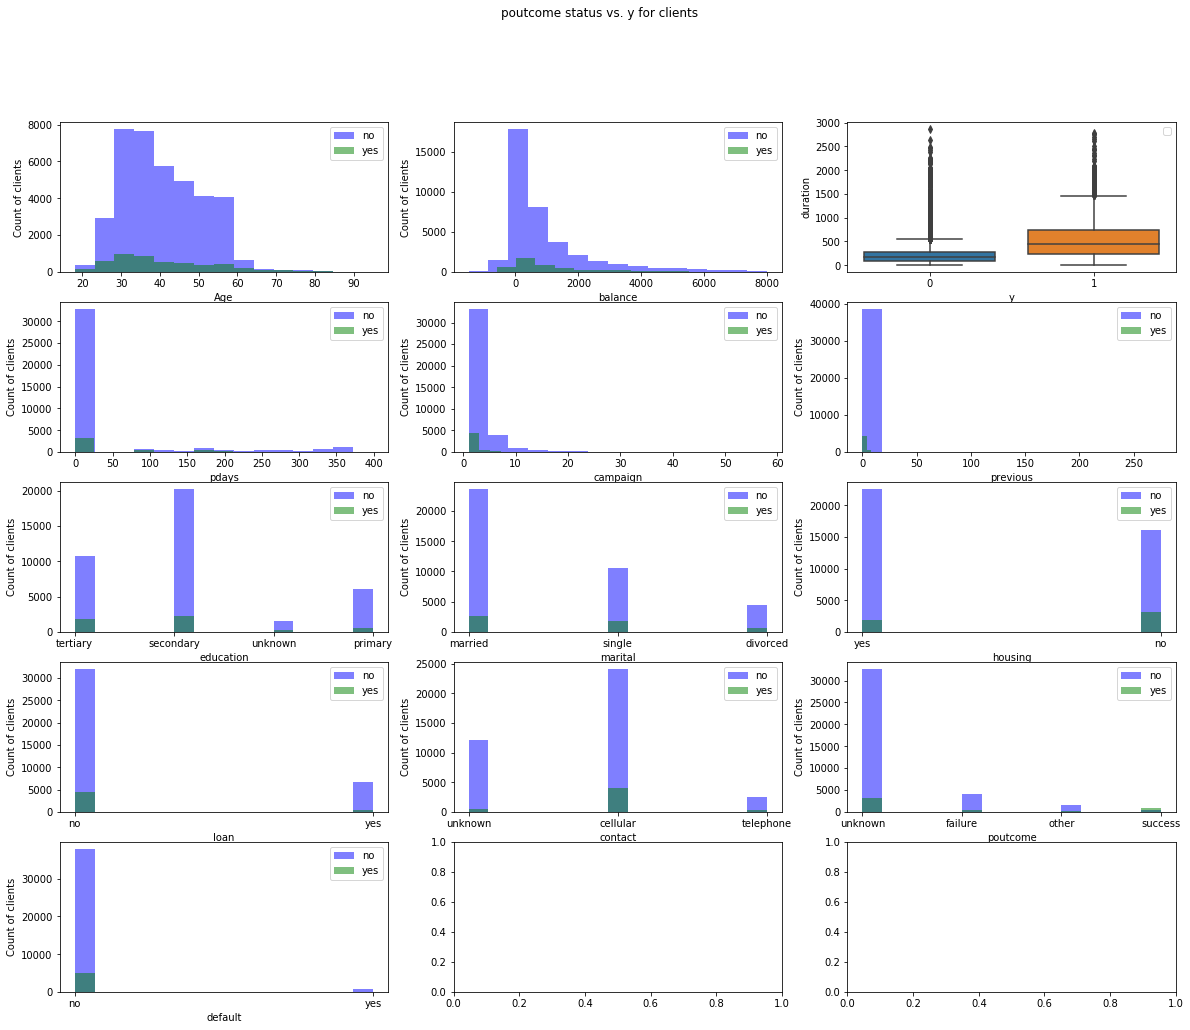

In [66]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20, 16))

##
ax[0,0].hist(bank_df[bank_df["y"]==0]["age"], bins=15, alpha=0.5, color="blue", label="no")
ax[0,0].hist(bank_df[bank_df["y"]==1]["age"], bins=15, alpha=0.5, color="green", label="yes")

ax[0,0].set_xlabel("Age")
ax[0,0].set_ylabel("Count of clients")

fig.suptitle("Age vs. y for clients")
ax[0,0].legend();

##
ax[0,1].hist(bank_df[bank_df["y"]==0]["balance"], bins=15, alpha=0.5, color="blue", label="no")
ax[0,1].hist(bank_df[bank_df["y"]==1]["balance"], bins=15, alpha=0.5, color="green", label="yes")

ax[0,1].set_xlabel("balance")
ax[0,1].set_ylabel("Count of clients")

fig.suptitle("balance vs. y for clients")
ax[0,1].legend()

##
sns.boxplot(x= bank_df["y"], y=bank_df["duration"], ax=ax[0,2])
#ax[0,2].hist(bank_df[bank_df["y"]==1]["duration"], bins=15, alpha=0.5, color="green", label="yes")
#ax[0,2].set_xlabel("pdays")
#ax[0,2].set_ylabel("Count of clients")
fig.suptitle("duration vs. y for clients")
ax[0,2].legend()

##
ax[1,0].hist(bank_df[bank_df["y"]==0]["pdays"], bins=15, alpha=0.5, color="blue", label="no")
ax[1,0].hist(bank_df[bank_df["y"]==1]["pdays"], bins=15, alpha=0.5, color="green", label="yes")
ax[1,0].set_xlabel("pdays")
ax[1,0].set_ylabel("Count of clients")

fig.suptitle("pdays vs. y for clients")
ax[1,0].legend()

##
ax[1,1].hist(bank_df[bank_df["y"]==0]["campaign"], bins=15, alpha=0.5, color="blue", label="no")
ax[1,1].hist(bank_df[bank_df["y"]==1]["campaign"], bins=15, alpha=0.5, color="green", label="yes")
ax[1,1].set_xlabel("campaign")
ax[1,1].set_ylabel("Count of clients")

fig.suptitle("campaign vs. y for clients")
ax[1,1].legend()

##
ax[1,2].hist(bank_df[bank_df["y"]==0]["previous"], bins=15, alpha=0.5, color="blue", label="no")
ax[1,2].hist(bank_df[bank_df["y"]==1]["previous"], bins=15, alpha=0.5, color="green", label="yes")
ax[1,2].set_xlabel("previous")
ax[1,2].set_ylabel("Count of clients")

fig.suptitle("previous vs. y for clients")
ax[1,2].legend()

##
ax[2,0].hist(bank_df[bank_df["y"]==0]["education"], bins=15, alpha=0.5, color="blue", label="no")
ax[2,0].hist(bank_df[bank_df["y"]==1]["education"], bins=15, alpha=0.5, color="green", label="yes")
ax[2,0].set_xlabel("education")
ax[2,0].set_ylabel("Count of clients")

fig.suptitle("education vs. y for clients")
ax[2,0].legend()


##
ax[2,1].hist(bank_df[bank_df["y"]==0]["marital"], bins=15, alpha=0.5, color="blue", label="no")
ax[2,1].hist(bank_df[bank_df["y"]==1]["marital"], bins=15, alpha=0.5, color="green", label="yes")
ax[2,1].set_xlabel("marital")
ax[2,1].set_ylabel("Count of clients")

fig.suptitle("marital status vs. y for clients")
ax[2,1].legend()

##
ax[2,2].hist(bank_df[bank_df["y"]==0]["housing"], bins=15, alpha=0.5, color="blue", label="no")
ax[2,2].hist(bank_df[bank_df["y"]==1]["housing"], bins=15, alpha=0.5, color="green", label="yes")
ax[2,2].set_xlabel("housing")
ax[2,2].set_ylabel("Count of clients")

fig.suptitle("housing status vs. y for clients")
ax[2,2].legend()

##

ax[3,0].hist(bank_df[bank_df["y"]==0]["loan"], bins=15, alpha=0.5, color="blue", label="no")
ax[3,0].hist(bank_df[bank_df["y"]==1]["loan"], bins=15, alpha=0.5, color="green", label="yes")
ax[3,0].set_xlabel("loan")
ax[3,0].set_ylabel("Count of clients")

fig.suptitle("housing status vs. y for clients")

##
ax[3,0].legend()
ax[3,1].hist(bank_df[bank_df["y"]==0]["contact"], bins=15, alpha=0.5, color="blue", label="no")
ax[3,1].hist(bank_df[bank_df["y"]==1]["contact"], bins=15, alpha=0.5, color="green", label="yes")
ax[3,1].set_xlabel("contact")
ax[3,1].set_ylabel("Count of clients")

fig.suptitle("contact status vs. y for clients")
ax[3,1].legend()

##
ax[3,2].hist(bank_df[bank_df["y"]==0]["poutcome"], bins=15, alpha=0.5, color="blue", label="no")
ax[3,2].hist(bank_df[bank_df["y"]==1]["poutcome"], bins=15, alpha=0.5, color="green", label="yes")
ax[3,2].set_xlabel("poutcome")
ax[3,2].set_ylabel("Count of clients")

fig.suptitle("poutcome status vs. y for clients")

ax[3,2].legend()

ax[4,0].hist(bank_df[bank_df["y"]==0]["default"], bins=15, alpha=0.5, color="blue", label="no")
ax[4,0].hist(bank_df[bank_df["y"]==1]["default"], bins=15, alpha=0.5, color="green", label="yes")
ax[4,0].set_xlabel("default")
ax[4,0].set_ylabel("Count of clients")


ax[4,0].legend()

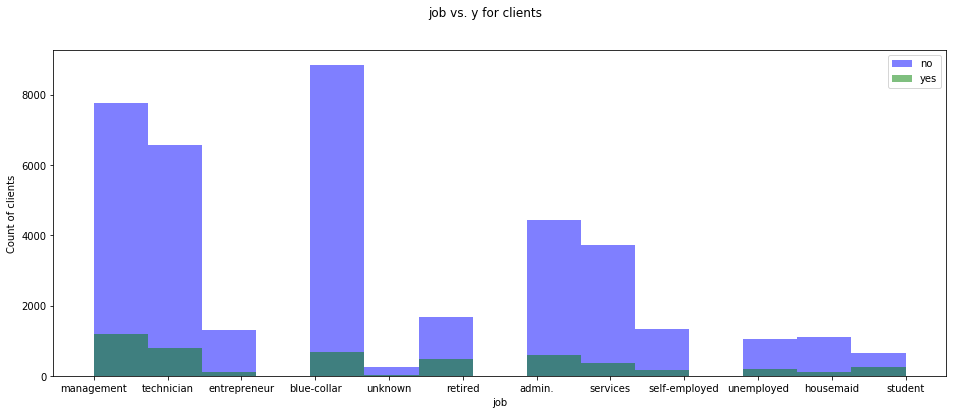

In [13]:
fig, ax = plt.subplots(figsize = (16, 6)) 

ax.hist(bank_df[bank_df["y"]==0]["job"], bins=15, alpha=0.5, color="blue", label="no")
ax.hist(bank_df[bank_df["y"]==1]["job"], bins=15, alpha=0.5, color="green", label="yes")

ax.set_xlabel("job")
ax.set_ylabel("Count of clients")

fig.suptitle("job vs. y for clients")

ax.legend();

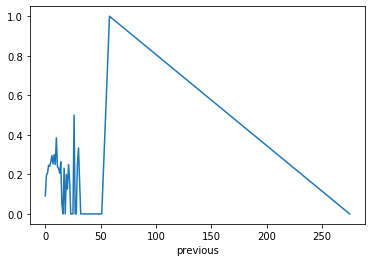

In [14]:
bank_df.groupby('previous')['y'].mean().plot()

In [15]:
df_cor = bank_df[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous' ]]

In [16]:
df_cor.corr()

,age,balance,duration,campaign,pdays,previous
age,1.000000,0.108310,-0.007370,0.005482,-0.024987,0.000619
balance,0.108310,1.000000,0.038012,-0.023649,0.010332,0.031937
duration,-0.007370,0.038012,1.000000,-0.086626,-0.001241,0.002087
campaign,0.005482,-0.023649,-0.086626,1.000000,-0.086331,-0.030881
pdays,-0.024987,0.010332,-0.001241,-0.086331,1.000000,0.459738
previous,0.000619,0.031937,0.002087,-0.030881,0.459738,1.000000


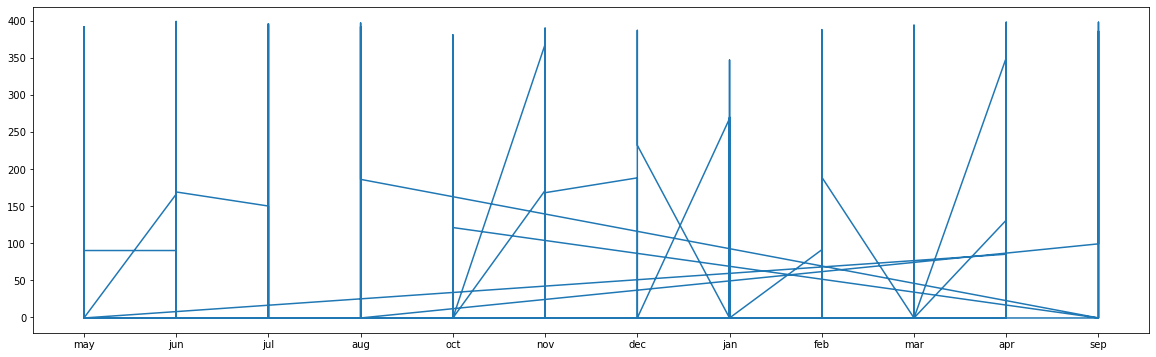

In [17]:
fig, ax = plt.subplots(figsize = (20, 6)) 

ax.plot( bank_df['month'], bank_df['pdays'])

## Findings from the visualization:

1.There are variances of outcome target on the features of balance, duration, housing, and campaign. 
2.the continuous variables have low correlation with each other. So that, there is no neccesary to remove features due to high correlations. 

## one hot encode, standardize, and split the data for modeling:

In [18]:
df_set = bank_df.copy()
df_set['default']=(df_set['default']=='yes').astype('int')
df_set['housing']=(df_set['housing']=='yes').astype('int')
df_set['loan'] = (df_set['loan']=='yes').astype('int')
len(df_set)

43641

In [19]:
ohe = OneHotEncoder(sparse = False)

In [20]:
ohe_job = pd.DataFrame(ohe.fit_transform(pd.DataFrame(df_set['job'])), columns = ohe.get_feature_names())
ohe_marital = pd.DataFrame(ohe.fit_transform(pd.DataFrame(df_set['marital'])), columns = ohe.get_feature_names())
ohe_edu = pd.DataFrame(ohe.fit_transform(pd.DataFrame(df_set['education'])), columns = ohe.get_feature_names())
ohe_contact = pd.DataFrame(ohe.fit_transform(pd.DataFrame(df_set['contact'])), columns = ohe.get_feature_names())
ohe_month = pd.DataFrame(ohe.fit_transform(pd.DataFrame(df_set['month'])), columns = ohe.get_feature_names())
ohe_poutcome = pd.DataFrame(ohe.fit_transform(pd.DataFrame(df_set['poutcome'])), columns = ohe.get_feature_names())

In [21]:
df_encode = pd.concat([df_set, ohe_job], axis = 1)
df_encode = pd.concat([df_encode, ohe_marital], axis = 1)
df_encode = pd.concat([df_encode, ohe_edu], axis = 1)
df_encode = pd.concat([df_encode, ohe_contact], axis = 1)
df_encode = pd.concat([df_encode, ohe_month], axis = 1)
df_encode = pd.concat([df_encode, ohe_poutcome], axis = 1).dropna()

In [22]:
X = df_encode.drop(['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'day', 'day_month', 'y'], axis=1)
y = df_encode['y']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

## Build the predictive model 
Stacking model is applied in this project

In [25]:
estimators = [  
              ('rf', RandomForestClassifier(n_estimators = 100)),
              ('log', LogisticRegression(solver = 'liblinear')),
              ('grad', GradientBoostingClassifier())]
stack = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(), cv = 5)
stack.fit(X_train, y_train);
stack.score(X_train, y_train)

0.9946691060500915

In [26]:
def metrics(y_true, y_pred):
    print('Accuracy: ' + str(accuracy_score(y_true, y_pred)))
    print('Precision: ' + str(precision_score(y_true, y_pred)))
    print('Recall: ' + str(recall_score(y_true, y_pred)))
    print('F1: ' + str(f1_score(y_true, y_pred)))
    print('\n')

In [27]:
metrics(y_test, stack.predict(X_test))

Accuracy: 0.9122823618470856
Precision: 0.5742574257425742
Recall: 0.39341085271317827
F1: 0.4669350201265095




In [28]:
for i in stack.estimators_:
    print(i)
    metrics(y_test, i.predict(X_test))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy: 0.9120931112793338
Precision: 0.6032064128256514
Recall: 0.2916666666666667
F1: 0.3932070542129327


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.

In [29]:
estimators = [  
              ('rf', RandomForestClassifier(n_estimators = 100, class_weight='balanced')),
              ('log', LogisticRegression(solver = 'liblinear', class_weight='balanced')),
              ('grad', GradientBoostingClassifier())]
stack_1 = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(class_weight='balanced'), cv = 5)
stack_1.fit(X_train, y_train);
stack_1.score(X_train, y_train)

0.9206043782726642

In [30]:
for i in stack_1.estimators_:
    print(i)
    metrics(y_test, i.predict(X_test))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy: 0.9084973504920515
Precision: 0.5862068965517241
Recall: 0.21414728682170542
F1: 0.3136976579134137


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
metrics(y_test, stack_1.predict(X_test))

Accuracy: 0.8565480696442089
Precision: 0.3904977375565611
Recall: 0.8362403100775194
F1: 0.5323874151758173




In [34]:
print(stack.final_estimator_.coef_)
print(stack_1.final_estimator_.coef_)
print(stack_2.final_estimator_.coef_)

[[ 5.58040678 -0.359494    2.93953069]]
[[6.10759901 2.82808743 0.59627179]]
[[7.68901197 3.33581784]]


In [35]:
estimators = [  
              ('rf', RandomForestClassifier(n_estimators = 100, class_weight='balanced')),
              ('grad', GradientBoostingClassifier())
            ]
stack_2 = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(class_weight='balanced'), cv = 5)
stack_2.fit(X_train, y_train);
stack_2.score(X_train, y_train)

0.9490252980884487

In [36]:
metrics(y_test, stack_2.predict(X_test))

Accuracy: 0.8719719909159728
Precision: 0.42081894425259003
Recall: 0.8265503875968992
F1: 0.5576985943118666




In [37]:
print("stack model logistic regression model coefficients:")
print(pd.DataFrame(stack.estimators_[1].coef_.round(3),columns=X.columns).T)
#print(pd.DataFrame(stack.estimators_[0].feature_importances_.round(3), X.columns.T))
print("stack_1 model logistic regression model coefficients:")
print(pd.DataFrame(stack_1.estimators_[1].coef_.round(3),columns=X.columns).T)

stack model logistic regression model coefficients:
                      0
age              -0.036
default          -0.001
balance           0.118
housing          -0.465
loan             -0.162
duration          1.070
campaign         -0.376
pdays            -0.036
previous          0.139
x0_admin.         0.028
x0_blue-collar   -0.084
x0_entrepreneur  -0.029
x0_housemaid     -0.019
x0_management    -0.010
x0_retired        0.097
x0_self-employed -0.005
x0_services      -0.001
x0_student        0.087
x0_technician     0.007
x0_unemployed     0.021
x0_unknown        0.001
x0_divorced      -0.027
x0_married       -0.007
x0_single         0.027
x0_primary       -0.001
x0_secondary     -0.012
x0_tertiary       0.014
x0_unknown        0.000
x0_cellular       0.226
x0_telephone      0.142
x0_unknown       -0.314
x0_apr            0.159
x0_aug           -0.034
x0_dec            0.065
x0_feb           -0.175
x0_jan           -0.058
x0_jul           -0.140
x0_jun            0.072
x0_mar      

In [38]:
print("stack model rf model feature_omportance:")
print(pd.DataFrame(stack.estimators_[0].feature_importances_.round(3), X.columns.T))
print("stack_1 model rf model feature_omportance:")
print(pd.DataFrame(stack_1.estimators_[0].feature_importances_.round(3), X.columns.T))
print("stack_2 model rf model feature_omportance:")
print(pd.DataFrame(stack_2.estimators_[0].feature_importances_.round(3), X.columns.T))

stack model rf model feature_omportance:
                      0
age               0.116
default           0.002
balance           0.112
housing           0.027
loan              0.012
duration          0.295
campaign          0.044
pdays             0.040
previous          0.023
x0_admin.         0.011
x0_blue-collar    0.011
x0_entrepreneur   0.004
x0_housemaid      0.004
x0_management     0.011
x0_retired        0.008
x0_self-employed  0.005
x0_services       0.009
x0_student        0.005
x0_technician     0.012
x0_unemployed     0.005
x0_unknown        0.001
x0_divorced       0.009
x0_married        0.015
x0_single         0.014
x0_primary        0.009
x0_secondary      0.014
x0_tertiary       0.012
x0_unknown        0.006
x0_cellular       0.009
x0_telephone      0.006
x0_unknown        0.009
x0_apr            0.013
x0_aug            0.011
x0_dec            0.003
x0_feb            0.007
x0_jan            0.006
x0_jul            0.008
x0_jun            0.005
x0_mar            0.004

In [40]:
X.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign',
       'pdays', 'previous', 'x0_admin.', 'x0_blue-collar', 'x0_entrepreneur',
       'x0_housemaid', 'x0_management', 'x0_retired', 'x0_self-employed',
       'x0_services', 'x0_student', 'x0_technician', 'x0_unemployed',
       'x0_unknown', 'x0_divorced', 'x0_married', 'x0_single', 'x0_primary',
       'x0_secondary', 'x0_tertiary', 'x0_unknown', 'x0_cellular',
       'x0_telephone', 'x0_unknown', 'x0_apr', 'x0_aug', 'x0_dec', 'x0_feb',
       'x0_jan', 'x0_jul', 'x0_jun', 'x0_mar', 'x0_may', 'x0_nov', 'x0_oct',
       'x0_sep', 'x0_failure', 'x0_other', 'x0_success', 'x0_unknown'],
      dtype='object')

In [41]:
X_1 = X.drop(['x0_admin.', 'x0_blue-collar', 'x0_entrepreneur',
       'x0_housemaid', 'x0_management', 'x0_retired', 'x0_self-employed',
       'x0_services', 'x0_student', 'x0_technician', 'x0_unemployed',
       'x0_unknown', 'x0_divorced', 'x0_married', 'x0_single', 'x0_primary',
       'x0_secondary', 'x0_tertiary', 'x0_unknown'], axis=1)

In [42]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y, random_state=42)

In [43]:
ss = StandardScaler()

X_train_1 = ss.fit_transform(X_train_1)
X_test_1 = ss.fit_transform(X_test_1)

In [44]:
estimators = [  
              ('rf', RandomForestClassifier(n_estimators = 100, class_weight='balanced')),
              ('grad', GradientBoostingClassifier())
            ]
stack_3 = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(class_weight='balanced'), cv = 5)
stack_3.fit(X_train_1, y_train_1);
stack_3.score(X_train_1, y_train_1)

0.9436944041385401

In [46]:
metrics(y_test_1, stack_3.predict(X_test_1))

Accuracy: 0.877554882664648
Precision: 0.4316996871741397
Recall: 0.8023255813953488
F1: 0.5613559322033898




In [ ]:
print(confusion_)

In [45]:
estimators = [  
              ('rf', RandomForestClassifier(n_estimators = 100)),
              ('grad', GradientBoostingClassifier())
            ]
stack_4 = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(class_weight='balanced'), cv = 5)
stack_4.fit(X_train_1, y_train_1);
stack_4.score(X_train_1, y_train_1)

0.9461548167308056

In [47]:
metrics(y_test_1, stack_4.predict(X_test_1))

Accuracy: 0.8765140045420137
Precision: 0.428496595075956
Recall: 0.7926356589147286
F1: 0.5562733764025841


